In [56]:
import numpy as np
import ROOT
from scipy.optimize import curve_fit as spyfit

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',**{'family':'sans-serif', 'sans-serif':['Helvetica'], 'size':'20'})
plt.rcParams['figure.figsize'] = '10,10'
plt.style.use('seaborn-white')

In [4]:
n_events = int(5e8)
noise_in_gev = 0.250
phys_events = np.random.exponential(3, n_events)
noise = np.random.normal(0, noise_in_gev, n_events)
np.savez_compressed("eflow_phase2_data", phys=phys_events, noise=noise)

In [4]:
data = np.load('eflow_phase2_data.npz')

phys_events_shift = {}
noise_shift = {}
s_shift = {}

n_events = int(1e7)
noise_in_gev = 0.250
for shift in np.linspace(0.9, 1.1, 21):
    phys_events_shift[round(shift, 2)] = np.random.choice(data['phys'], int(n_events*0.05))*np.full(int(n_events*0.05), shift)
    phys_events_shift[round(shift, 2)] = np.append(phys_events_shift[round(shift, 2)], np.full(n_events-int(n_events*0.05), 0))
    np.random.shuffle(phys_events_shift[round(shift, 2)])
    noise_shift[round(shift, 2)] = np.random.choice(data['noise'], n_events)
    s_shift[round(shift, 2)] = (phys_events_shift[round(shift, 2)]+noise_shift[round(shift, 2)]).mean()

del data

In [5]:
k_graph = ROOT.TGraph()
for shift,s in s_shift.items():
    k_graph.SetPoint(k_graph.GetN(), shift-1, s/s_shift[1.00]-1)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =  4.32245e-05
NDf                       =           19
Edm                       =  4.26464e-22
NCalls                    =           24
p0                        =     0.998633   +/-   0.00543554  
p1                        =  0.000240875   +/-   0.000329138 


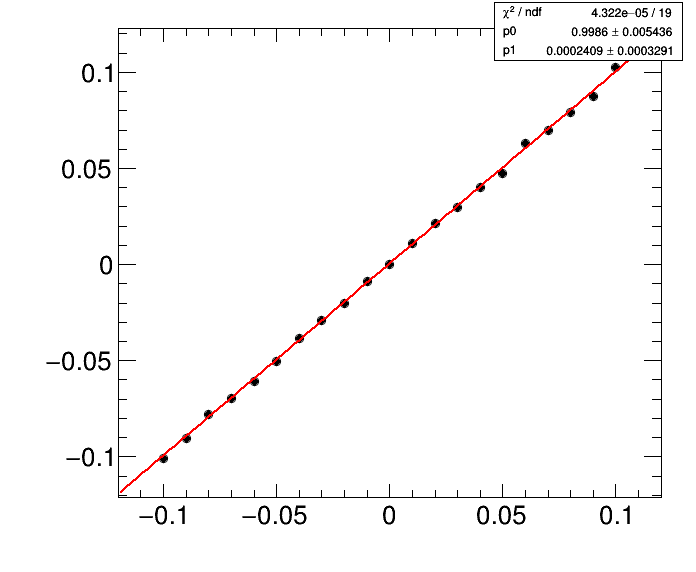

In [6]:
c = ROOT.TCanvas()
k_graph.Draw("AP")
k_fit = ROOT.TF1("k_fit", "[0]*x+[1]", -0.2, 0.2)
#k_fit.FixParameter(0, 1.)
k_graph.Fit(k_fit)
c.Draw()

In [8]:
pulls = []
sample_sizes = [1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6]
for size in sample_sizes:
    s0 = (np.random.choice(phys_events_shift[1.00], size=int(size))+np.random.choice(noise_shift[1.00], size=int(size))).mean()
    pull_vect = []
    for shift in phys_events_shift.keys():
        s = (np.random.choice(phys_events_shift[shift], size=int(size))+np.random.choice(noise_shift[shift], size=int(size))).mean()
        pull_vect.append((s/s0-shift)/shift)
    pulls.append(pull_vect)

pulls.append([(s/s0-i)/i for i,s in s_shift.items()])
sample_sizes.append(1e7)    
    


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


Fit parameters: [   5.10685473 -689.34987446]
Error matrix: [ 0.45468842 91.6550149 ]


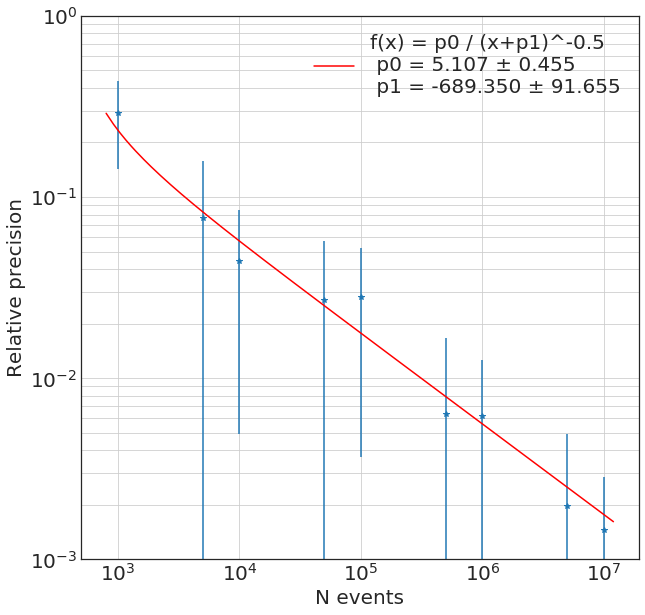

In [99]:
h = plt.errorbar(sample_sizes, [abs(np.array(pull).mean()) for pull in pulls], yerr=[np.array(pull).std() for pull in pulls], marker='*', linestyle='')
f = lambda x, p0, p1 : p0*np.power(x+p1, -0.5)
popt, pcov = spyfit(f, sample_sizes, [abs(np.array(pull).mean()) for pull in pulls], sigma=[np.array(pull).std() for pull in pulls], p0=[1000, 0.01])
perr = np.sqrt(np.diag(pcov))
h = plt.plot(np.linspace(sample_sizes[0]*0.8, sample_sizes[-1]*1.2, 100000), f(np.linspace(sample_sizes[0], sample_sizes[-1], 100000), *popt), 'r',
             label='f(x) = p0 / (x+p1)^-0.5 \n p0 = %5.3f \xb1 %5.3f \n p1 = %5.3f \xb1 %5.3f' %
             (popt[0], perr[0], popt[1], perr[1]))
plt.legend()
plt.yscale('log')
plt.ylim(0.001, 1.)
plt.grid(which='both', axis='y')
plt.grid(axis='x')
plt.ylabel('Relative precision')
plt.xlabel('N events')
plt.xscale('log')

print("Fit parameters:", popt)
print("Error matrix:", perr)